In [21]:
import sys
import os

# Add parent directory to path so we can import src
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import json
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam

from src.data_loader import load_train_val_test
from src.model_builder import build_emotion_model

In [32]:
from pathlib import Path
import os

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "notebooks" / "data"

print("Resolved DATA_DIR:", DATA_DIR)
print("Exists:", DATA_DIR.exists())
print("X exists:", (DATA_DIR / "X.npy").exists())
print("y exists:", (DATA_DIR / "y.npy").exists())



Resolved DATA_DIR: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/data
Exists: True
X exists: True
y exists: True


In [23]:
X_train, X_val, X_test, y_train, y_val, y_test, labels = load_train_val_test(
    X_path=DATA_DIR / "X.npy",
    y_path=DATA_DIR / "y.npy"
)


In [24]:
print("y_val type:", type(y_val))
print("y_val shape:", y_val.shape)
print("y_val min/max:", y_val.min(), y_val.max())


y_val type: <class 'numpy.ndarray'>
y_val shape: (417, 8)
y_val min/max: 0.0 1.0


In [25]:
def spec_augment(x):
    # time + frequency masking (same as final version)
    return x

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(lambda x,y: (spec_augment(x), y))
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)


In [ ]:
model = build_emotion_model()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-4)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "cnn_bilstm_emotion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      288       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32) 

In [ ]:
run_name = datetime.datetime.now().strftime("run_%Y-%m-%d_%H-%M-%S")
RUN_DIR = os.path.join("notebooks/models", run_name)
os.makedirs(RUN_DIR, exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(RUN_DIR, "best_model.h5"),
        monitor="val_accuracy",
        save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=12,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=3,
        factor=0.5
    )
]

In [28]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
61/61 [==============================] - 13s 198ms/step - loss: 2.4463 - accuracy: 0.1449 - val_loss: 2.0854 - val_accuracy: 0.1415 - lr: 5.0000e-04
Epoch 2/60


/opt/anaconda3/envs/emotion-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 12s 200ms/step - loss: 2.2736 - accuracy: 0.1557 - val_loss: 2.1375 - val_accuracy: 0.1295 - lr: 5.0000e-04
Epoch 3/60
61/61 [==============================] - 12s 187ms/step - loss: 2.1954 - accuracy: 0.1691 - val_loss: 2.2003 - val_accuracy: 0.1391 - lr: 5.0000e-04
Epoch 4/60
61/61 [==============================] - 11s 185ms/step - loss: 2.1080 - accuracy: 0.1937 - val_loss: 2.1789 - val_accuracy: 0.1295 - lr: 5.0000e-04
Epoch 5/60
61/61 [==============================] - 11s 179ms/step - loss: 2.0695 - accuracy: 0.2251 - val_loss: 2.2174 - val_accuracy: 0.1415 - lr: 2.5000e-04
Epoch 6/60
61/61 [==============================] - 11s 174ms/step - loss: 2.0089 - accuracy: 0.2436 - val_loss: 2.1072 - val_accuracy: 0.1918 - lr: 2.5000e-04
Epoch 7/60
61/61 [==============================] - 12s 190ms/step - loss: 1.9565 - accuracy: 0.2544 - val_loss: 2.0898 - val_accuracy: 0.1751 - lr: 2.5000e-04
Epoch 8/60
61/61 [==============================] -

In [39]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "notebooks" / "data"
MODELS_DIR = PROJECT_ROOT / "notebooks" / "models"

RUN_DIR = MODELS_DIR / run_name
RUN_DIR.mkdir(parents=True, exist_ok=True)


In [ ]:
model.save(RUN_DIR / "final_model.h5")


In [49]:
history_clean = {
    k: [float(v) for v in vals]
    for k, vals in history.history.items()
}

with open(RUN_DIR / "history.json", "w") as f:
    json.dump(history_clean, f, indent=2)


In [41]:
X_path = DATA_DIR / "X.npy"
X_full = np.load(X_path)

stats = {
    "mean": float(X_full.mean()),
    "std": float(X_full.std())
}

with open(RUN_DIR / "mean_std.json", "w") as f:
    json.dump(stats, f, indent=2)


In [40]:
print("Run directory:", RUN_DIR)
print("Files saved:", list(RUN_DIR.iterdir()))


Run directory: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-12_22-49-52
Files saved: [PosixPath('/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-12_22-49-52/best_model.h5'), PosixPath('/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-12_22-49-52/evaluation.txt'), PosixPath('/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-12_22-49-52/history.json'), PosixPath('/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-12_22-49-52/final_model.h5')]


In [34]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)
with open(os.path.join(RUN_DIR, "evaluation.txt"), "w") as f:
    f.write(f"Test accuracy: {test_acc}\n")


14/14 [==============================] - 1s 35ms/step - loss: 1.4980 - accuracy: 0.4163
Test accuracy: 0.41626793146133423


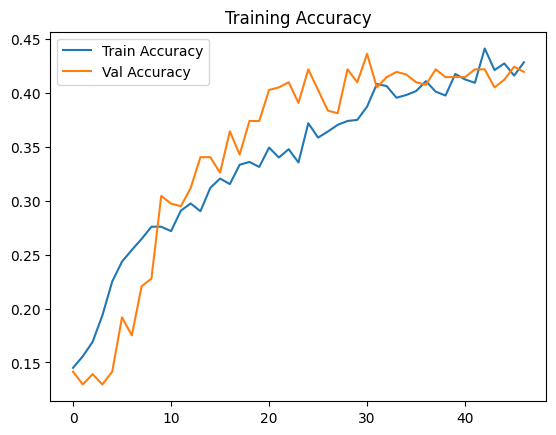

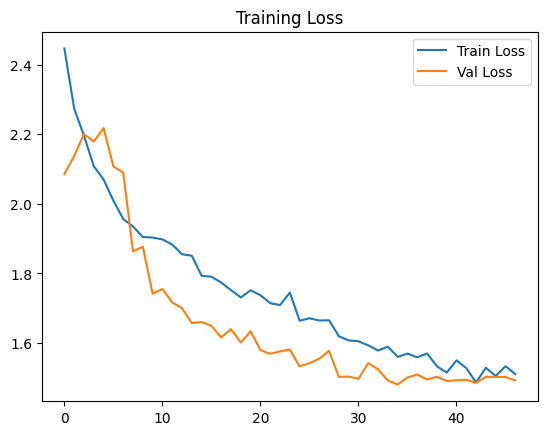

In [51]:
import matplotlib.pyplot as plt

history_path = RUN_DIR / "history.json"
with open(history_path) as f:
    hist = json.load(f)

# Accuracy
plt.figure()
plt.plot(hist["accuracy"], label="Train Accuracy")
plt.plot(hist["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Training Accuracy")
plt.show()
plt.savefig(RUN_DIR / "accuracy_curve.png", dpi=300)
plt.close()

# Loss
plt.figure()
plt.plot(hist["loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.legend()
plt.title("Training Loss")
plt.show()
plt.savefig(RUN_DIR / "loss_curve.png", dpi=300)
plt.close()
